In [23]:
import cv2
import json
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines)
from src.utils.const import ref_snooker_playfield
from src.utils.playfield_finder import PlayfieldFinder
from src.utils.points import Point
from src.utils.lines import Line
import numpy as np
from src.utils.plotting import display_img, plot_on_image
import src.config
from src.utils.metrics import iou, _reorder_pts
from src.utils.intersections import compute_intersections
from src.utils.annotations import transform_annotation
from pathlib import Path
import pandas as pd
from src.utils.annotations import PolygonAnnotation

In [24]:
picname = 'pic_05_18_01'
pic = read_image_as_numpyimage(f'pics/{picname}.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png  pic_08_08_01.png pic_06_16_02.png
cropped_pic = crop_center(pic)

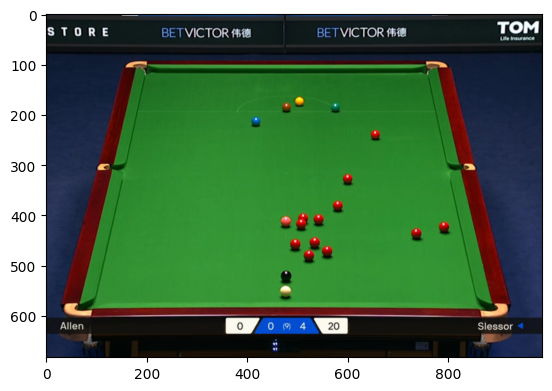

In [25]:
display_img(pic)

#### find playfield

In [26]:
finder = PlayfieldFinder(pic)

##### find internal side cushions

In [27]:
internal_side_cushions = finder.find_side_cushions()
internal_side_cushions = sorted(internal_side_cushions, key=lambda line: line.slope)
left_internal_side_cushion = internal_side_cushions[0]
right_internal_side_cushion = internal_side_cushions[1]

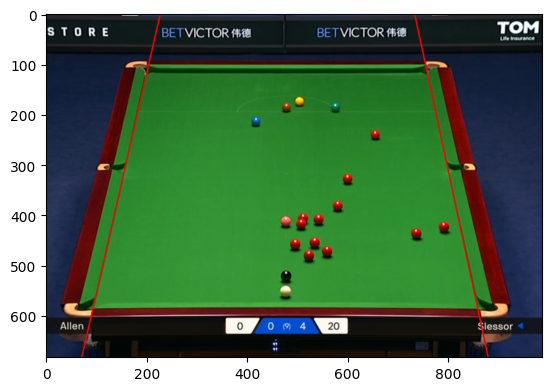

In [28]:
display_img(plot_on_image(pic, lines=internal_side_cushions))

##### find internal top cushion

In [29]:
internal_top_cushion = finder.find_top_internal_cushion()
internal_top_cushion

y = 0.0 * x + 109.0

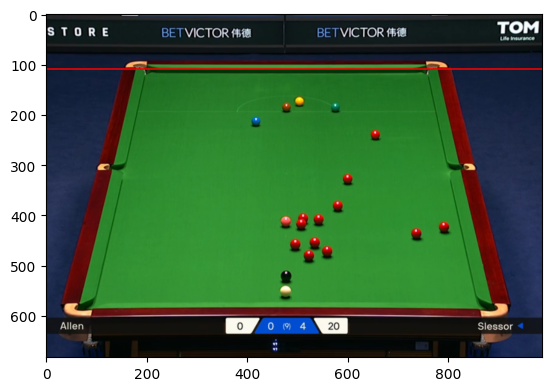

In [30]:
display_img(plot_on_image(pic, lines=[internal_top_cushion]))

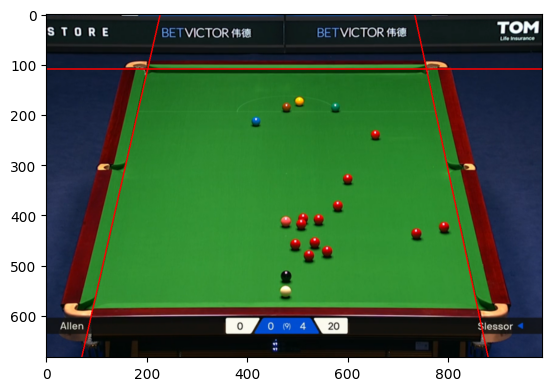

In [31]:
display_img(plot_on_image(pic, lines=[internal_top_cushion] + internal_side_cushions))

##### baulk line detection

In [32]:
baulk_line = finder.find_baulk_line()
baulk_line

y = 0.0 * x + 194.0

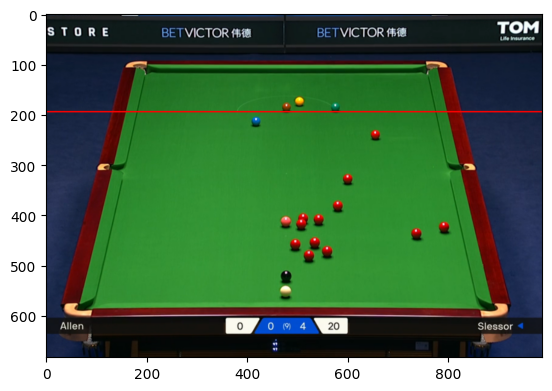

In [33]:
display_img(plot_on_image(pic, lines=[baulk_line]))

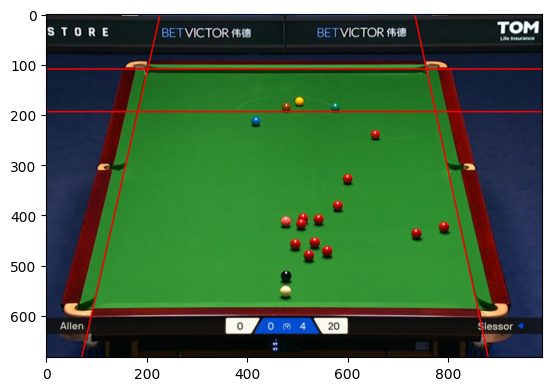

In [34]:
display_img(plot_on_image(pic, lines=[baulk_line] + [internal_top_cushion] + internal_side_cushions))

##### find internal bottom cushion

In [35]:
internal_bottom_cushion = finder.find_bottom_internal_cushion()
internal_bottom_cushion

y = 0.0 * x + 574.0

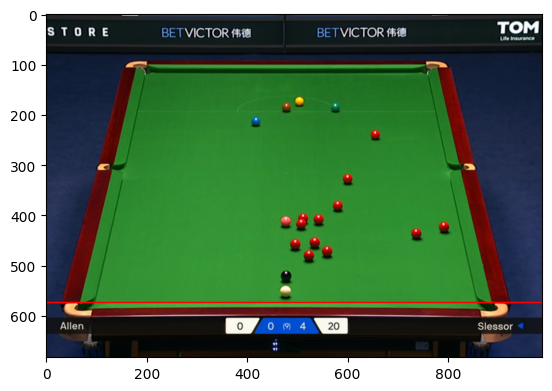

In [36]:
display_img(plot_on_image(pic, lines=[internal_bottom_cushion]))

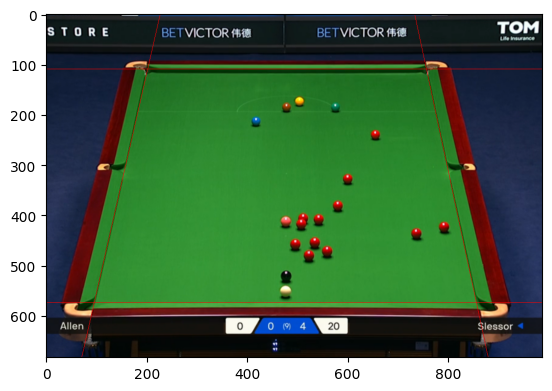

In [37]:
display_img(plot_on_image(pic, lines=[internal_bottom_cushion] + [internal_top_cushion] + internal_side_cushions, line_thickness=1))


In [38]:
intersections = compute_intersections(lines=[internal_bottom_cushion] + [internal_top_cushion] + internal_side_cushions, image=pic)

In [39]:
intersections

[Point (95, 574) line1: [y = -4.36 * x + 992.06] line2: [y = 0.00 * x + 574.00],
 Point (857, 574) line1: [y = 0.00 * x + 574.00] line2: [y = 4.67 * x + -3434.82],
 Point (202, 109) line1: [y = -4.36 * x + 992.06] line2: [y = 0.00 * x + 109.00],
 Point (758, 109) line1: [y = 0.00 * x + 109.00] line2: [y = 4.67 * x + -3434.82]]

#### playfield ground truth

In [40]:
polygon_annp = PolygonAnnotation(root_dir='playfield_gt')

In [41]:
polygon_annp.concat_files()
polygon_annp.clean_annotations

[PolygonAnnotationData(points=[[21.56872416546001, 16.90290902353159], [80.42953337754462, 16.698480449194538], [90.76790489458021, 86.7665678463344], [11.091730982024973, 86.57973565561119]], image=ImageData(name='pic_01_04_01.png', width=1188, height=830)),
 PolygonAnnotationData(points=[[11.378165247222933, 88.5329812858996], [85.9932969153067, 89.12049904267802], [76.2709776548382, 19.046847013773085], [21.238598616368872, 18.85229448459021]], image=ImageData(name='pic_01_05_01.png', width=1265, height=832)),
 PolygonAnnotationData(points=[[9.303616193280698, 82.50957321968995], [89.90389669670242, 82.29571984435799], [78.77749070047128, 12.817305910691124], [19.57982803459666, 13.011858439874002]], image=ImageData(name='pic_01_06_01.png', width=1165, height=832)),
 PolygonAnnotationData(points=[[18.457356356528866, 17.879531838675813], [79.13189682445288, 17.677258971033293], [89.8920986617451, 85.42400098820333], [7.845487505997592, 84.24124513618678]], image=ImageData(name='pic_

In [42]:
points_gt = polygon_annp.filter_by_image(f'{picname}.png').points
points_gt = np.asarray(transform_annotation(pic, points_gt))

In [43]:
points = np.asarray([point.point for point in intersections])
points = _reorder_pts(points_gt, points)

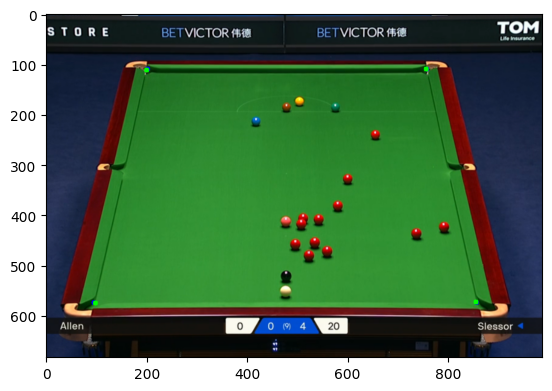

0.9918180674442917

In [44]:
pic_copy3 = pic.copy()
for point_gt, point in zip(points_gt, points):
    cv2.circle(pic_copy3, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)
    cv2.circle(pic_copy3, (int(point_gt[0]), int(point_gt[1])), 5, (0, 255, 0), -1)

display_img(pic_copy3)
iou(points_gt, points)

#### petla

In [46]:
root = Path('pics')

# count = sum(1 for p in root.iterdir() if p.is_file())
# count = len(list(root.glob("*.png")))

ious = []
pic_names = []
for file in sorted(root.glob('*.png')):
    pic = read_image_as_numpyimage(file, 'rgb')
    finder = PlayfieldFinder(pic)
    
    iou_value = None

    try:
        internal_side_cushions = finder.find_side_cushions()
        internal_top_cushion = finder.find_top_internal_cushion()
        internal_bottom_cushion = finder.find_bottom_internal_cushion()

        intersections = compute_intersections(lines=[internal_bottom_cushion] + [internal_top_cushion] + internal_side_cushions, image=pic)
        points = np.asarray([point.point for point in intersections])
     
        data = polygon_annp.filter_by_image(file.name)
        points_gt = np.asarray(transform_annotation(pic, data.points))

        iou_value = iou(points_gt, points)

        if iou_value < 0.5:
            pic_copy3 = pic.copy()
            pic_copy3 = cv2.cvtColor(pic_copy3, cv2.COLOR_RGB2BGR)
            for point_gt, point in zip(points_gt, points):
                cv2.circle(pic_copy3, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)
                cv2.circle(pic_copy3, (int(point_gt[0]), int(point_gt[1])), 5, (0, 255, 0), -1)

            cv2.imwrite(f'iou_pics/{file.name}', pic_copy3)
        
        # display_img(plot_on_image(pic, lines=[internal_bottom_cushion] + [internal_top_cushion] + internal_side_cushions, line_thickness=1))
    except Exception as e:
        print(f'Error processing {file}: {e}')
        # display_img(pic)
    finally:
        pic_names.append(file.name)
        ious.append(iou_value)
        

Error processing pics/pic_01_10_01.png: can only concatenate list (not "NoneType") to list
Error processing pics/pic_01_17_01.png: can only concatenate list (not "NoneType") to list
Error processing pics/pic_01_33_01.png: can only concatenate list (not "NoneType") to list
Error processing pics/pic_01_41_02.png: can only concatenate list (not "NoneType") to list
Error processing pics/pic_01_43_01.png: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'

Error processing pics/pic_01_43_02.png: bad operand type for unary -: 'NoneType'
Error processing pics/pic_01_46_01.png: can only concatenate list (not "NoneType") to list
Error processing pics/pic_01_49_01.png: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'

Error processing pics/pic_02_05_01.png: 

In [31]:
pd.DataFrame({'pic_name': pic_names, 'iou': ious}).to_excel('iou.xlsx', index=False)